<a href="https://colab.research.google.com/github/piotrwrzodak/UAM-LANG-MODELING/blob/main/4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install datasets -q
%pip install seaborn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
dataset = load_dataset('mteb/tweet_sentiment_extraction')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/27481 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3534 [00:00<?, ? examples/s]

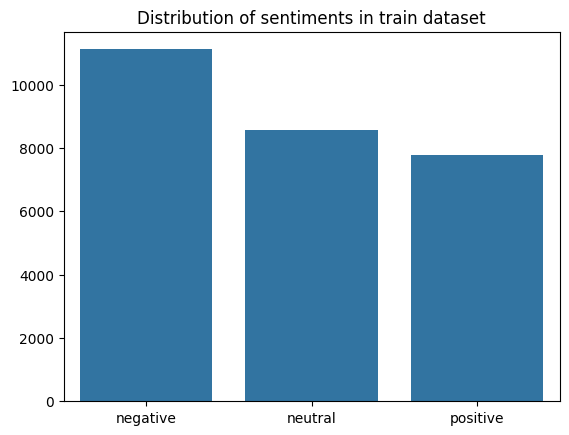

In [5]:
dd = pd.Series(dataset['train']['label_text']).value_counts()
sns.barplot(x=np.array(['negative', 'neutral', 'positive']), y=dd.values)
plt.title('Distribution of sentiments in train dataset')
plt.show()

Max length: 142


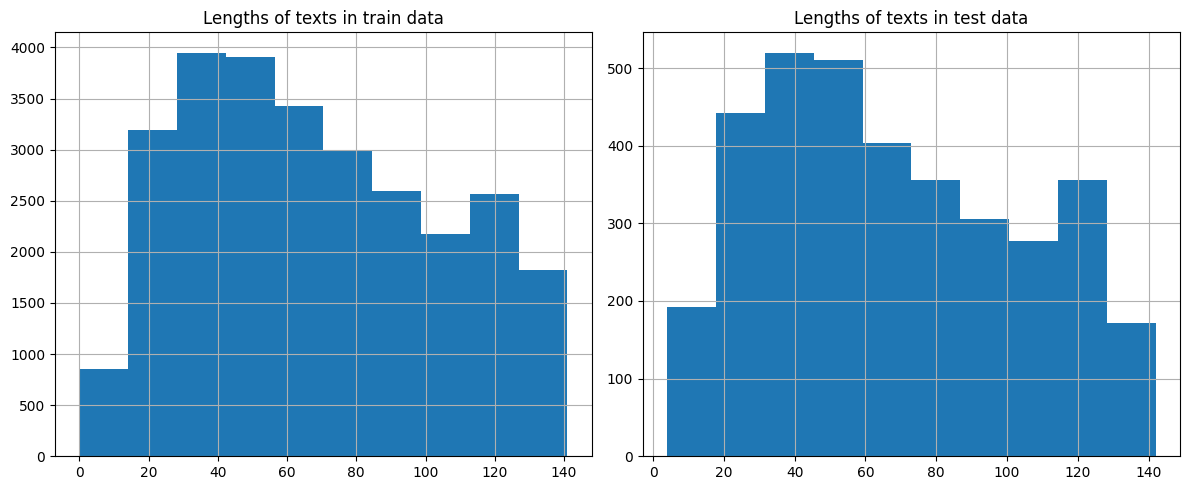

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

train_text_list = dataset['train']['text']
train_max_len = [len(text) for text in train_text_list]
pd.Series(train_max_len).hist(ax=axes[0])
axes[0].set_title('Lengths of texts in train data')

test_text_list = dataset['test']['text']
test_max_len = [len(text) for text in test_text_list]
pd.Series(test_max_len).hist(ax=axes[1])
axes[1].set_title('Lengths of texts in test data')

print(f"Max length: {max(max(train_max_len), max(test_max_len))}")
plt.tight_layout()
plt.show()

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_data(examples):
    texts = examples['text']
    labels = examples['label']

    encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=256)

    input_ids = encodings['input_ids']
    attention_masks = encodings['attention_mask']

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels
    }

encoded_dataset = dataset.map(preprocess_data, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/27481 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

In [8]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim * 2, output_dim)


    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.linear(hidden)


In [9]:
def prepare_dataloader(encoded_dataset, split, batch_size):
    input_ids = torch.tensor(encoded_dataset[split]['input_ids'])
    labels = torch.tensor(encoded_dataset[split]['labels'])

    dataset = TensorDataset(input_ids, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

batch_size = 32
train_dataloader = prepare_dataloader(encoded_dataset, 'train', batch_size)
val_dataloader = prepare_dataloader(encoded_dataset, 'test', batch_size)

In [10]:
vocab_size = tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 256
output_dim = 3
n_layers = 2
dropout = 0.5
learning_rate = 1e-3

model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model.to(device)

BiLSTMModel(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=512, out_features=3, bias=True)
)

In [11]:
class EarlyStopping:
    def __init__(self, patience=1, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        self.val_loss_min = val_loss


early_stopping = EarlyStopping()

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_dataloader:
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(input_ids)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device)
            outputs = model(input_ids)
            predictions = outputs.argmax(dim=1)
            val_loss += criterion(outputs, labels).item()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}\t Loss: {epoch_loss/len(train_dataloader)}\t Validation Loss: {avg_val_loss}\t Validation Accuracy: {val_accuracy:.4f}')

    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 1/10	 Loss: 0.7536720985999901	 Validation Loss: 0.6814414976953386	 Validation Accuracy: 0.7023
Epoch 2/10	 Loss: 0.6900485105925306	 Validation Loss: 0.6463802368254274	 Validation Accuracy: 0.7295
Epoch 3/10	 Loss: 0.6354646881883996	 Validation Loss: 0.6214216056170764	 Validation Accuracy: 0.7417
Epoch 4/10	 Loss: 0.5872660880004152	 Validation Loss: 0.6101295274120193	 Validation Accuracy: 0.7487
Epoch 5/10	 Loss: 0.5367449826286613	 Validation Loss: 0.6060683421186499	 Validation Accuracy: 0.7598
Epoch 6/10	 Loss: 0.4872793609556136	 Validation Loss: 0.6080408891042074	 Validation Accuracy: 0.7632
Early stopping
